# Multiple Regression: From Scratch vs Library (Window Size = 14)

- Dataset: `SnP_daily_update_AMZN_features_with_target.csv`
- Target: `y_ret_t1`
- Features: selected from `AMZN_methods_all_in_one.csv`
- Models:
  1. Multiple Linear Regression (from scratch via gradient descent)
  2. Multiple Linear Regression (scikit-learn)

Metrics printed:
- MSE, RMSE, MAE, R² (Train/Test: sklearn vs scratch)
- Accuracy (directional)
- F1 (directional)

Performance curves:
- Learning curve
- Actual vs Predict
- Actual vs Predict over time
- Residual distribution

Rows after cleaning: 4028
Number of features from AMZN_methods_all_in_one used: 15
Features used: ['lower_wick', 'vol_chg', 'ma_gap_20', 'vol_ratio_20', 'ret_1', 'upper_wick', 'co_ret', 'range_pct', 'ret_2', 'vol_10', 'ret_5', 'vol_20', 'ret_4', 'ma_gap_10', 'ret_3']

 REGRESSION METRICS: sklearn vs From Scratch 
      sklearn Train  Scratch Train  sklearn Test  Scratch Test
MSE        0.000398       0.000415      0.000462      0.000432
RMSE       0.019948       0.020367      0.021498      0.020790
MAE        0.014029       0.014207      0.015825      0.015379
R²         0.081835       0.042846     -0.127501     -0.054402

=== From Scratch (Multiple Linear Regression) ===
Loss (MSE): 0.00043222
Accuracy (Directional): 0.5056
F1 Score (Directional): 0.5604

=== Library (scikit-learn LinearRegression) ===
Loss (MSE): 0.00046218
Accuracy (Directional): 0.4932
F1 Score (Directional): 0.5284


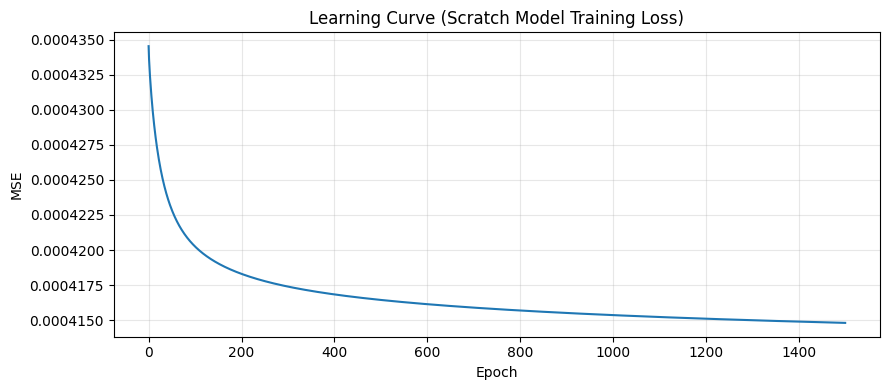

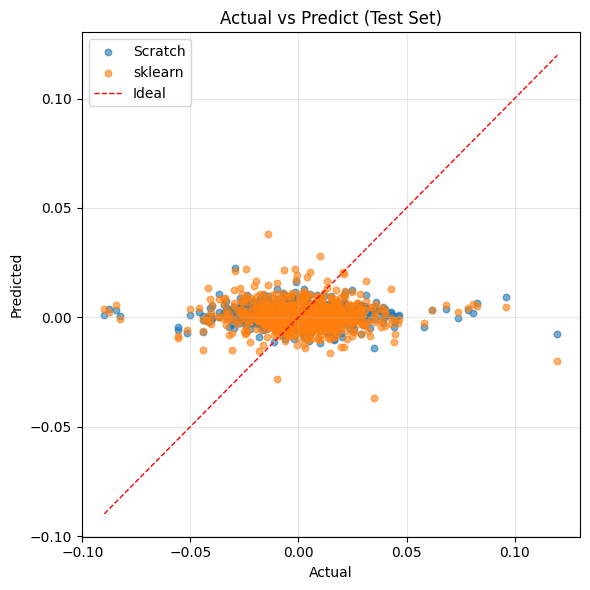

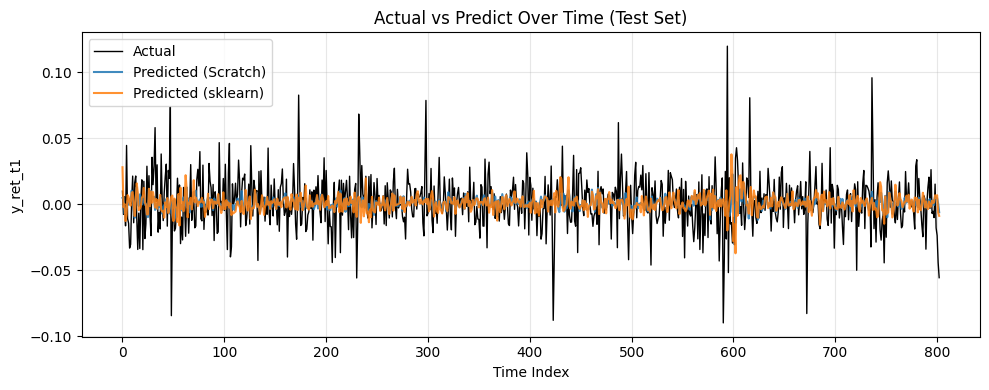

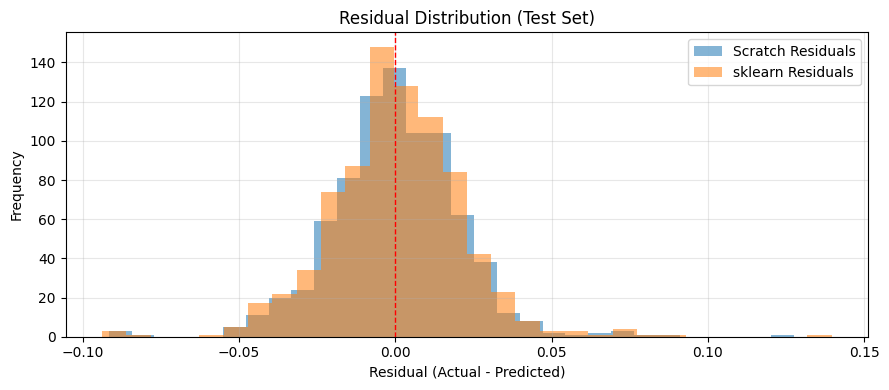

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score

WINDOW_SIZE = 14
DATA_PATH = 'SnP_daily_update_AMZN_features_with_target.csv'
FEATURE_PATH = 'AMZN_methods_all_in_one.csv'
TARGET_COL = 'y_ret_t1'

# --------------------------
# 1) Load data and features
# --------------------------
df = pd.read_csv(DATA_PATH)
feature_df = pd.read_csv(FEATURE_PATH)

# Keep feature order from AMZN_methods_all_in_one and only those existing in dataset
feature_cols = [c for c in feature_df['feature'].tolist() if c in df.columns and c != TARGET_COL]

# Basic cleaning and sorting (time series)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

model_df = df[feature_cols + [TARGET_COL]].copy()
model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

print(f'Rows after cleaning: {len(model_df)}')
print(f'Number of features from AMZN_methods_all_in_one used: {len(feature_cols)}')
print('Features used:', feature_cols)

# --------------------------------
# 2) Build sliding window features
# --------------------------------
def make_windows(x_values, y_values, window_size=14):
    Xw, yw = [], []
    for i in range(window_size, len(x_values)):
        # Flatten [window_size, n_features] -> [window_size * n_features]
        Xw.append(x_values[i-window_size:i].reshape(-1))
        yw.append(y_values[i])
    return np.array(Xw, dtype=np.float64), np.array(yw, dtype=np.float64)

X_raw = model_df[feature_cols].values.astype(np.float64)
y_raw = model_df[TARGET_COL].values.astype(np.float64)

X_win, y_win = make_windows(X_raw, y_raw, window_size=WINDOW_SIZE)

# Chronological split (80/20)
split_idx = int(len(X_win) * 0.8)
X_train_raw, X_test_raw = X_win[:split_idx], X_win[split_idx:]
y_train, y_test = y_win[:split_idx], y_win[split_idx:]

# Standardize by train statistics
x_mean = X_train_raw.mean(axis=0)
x_std = X_train_raw.std(axis=0)
x_std = np.where(x_std == 0, 1.0, x_std)

X_train = (X_train_raw - x_mean) / x_std
X_test = (X_test_raw - x_mean) / x_std

# ---------------------------------------------
# 3) Multiple Linear Regression from scratch GD
# ---------------------------------------------
class LinearRegressionScratch:
    def __init__(self, lr=0.01, epochs=1500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0.0
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features, dtype=np.float64)
        self.b = 0.0

        for _ in range(self.epochs):
            y_pred = X @ self.w + self.b
            error = y_pred - y

            # MSE loss
            loss = np.mean(error ** 2)
            self.loss_history.append(loss)

            # Gradients
            dw = (2.0 / n_samples) * (X.T @ error)
            db = (2.0 / n_samples) * np.sum(error)

            # Update
            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict(self, X):
        return X @ self.w + self.b

scratch_model = LinearRegressionScratch(lr=0.01, epochs=1500)
scratch_model.fit(X_train, y_train)
y_pred_scratch_train = scratch_model.predict(X_train)
y_pred_scratch = scratch_model.predict(X_test)

# -------------------------------------
# 4) Multiple Linear Regression library
# -------------------------------------
lib_model = LinearRegression()
lib_model.fit(X_train, y_train)
y_pred_lib_train = lib_model.predict(X_train)
y_pred_lib = lib_model.predict(X_test)

# ----------------------------------------------
# 5) Regression metrics table (like screenshot)
# ----------------------------------------------
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

lib_train_metrics = regression_metrics(y_train, y_pred_lib_train)
scratch_train_metrics = regression_metrics(y_train, y_pred_scratch_train)
lib_test_metrics = regression_metrics(y_test, y_pred_lib)
scratch_test_metrics = regression_metrics(y_test, y_pred_scratch)

metrics_table = pd.DataFrame({
    'sklearn Train': lib_train_metrics,
    'Scratch Train': scratch_train_metrics,
    'sklearn Test': lib_test_metrics,
    'Scratch Test': scratch_test_metrics
})

print('\n' + '=' * 78)
print(' REGRESSION METRICS: sklearn vs From Scratch ')
print('=' * 78)
print(metrics_table.to_string(float_format=lambda x: f'{x:.6f}'))

# ------------------------
# 6) Metrics: loss/acc/F1
# ------------------------
def directional_metrics(y_true, y_pred):
    true_dir = (y_true > 0).astype(int)
    pred_dir = (y_pred > 0).astype(int)
    acc = accuracy_score(true_dir, pred_dir)
    f1 = f1_score(true_dir, pred_dir, zero_division=0)
    return acc, f1, true_dir, pred_dir

mse_scratch = mean_squared_error(y_test, y_pred_scratch)
acc_scratch, f1_scratch, true_dir, pred_dir_scratch = directional_metrics(y_test, y_pred_scratch)

mse_lib = mean_squared_error(y_test, y_pred_lib)
acc_lib, f1_lib, _, pred_dir_lib = directional_metrics(y_test, y_pred_lib)

print('\n=== From Scratch (Multiple Linear Regression) ===')
print(f'Loss (MSE): {mse_scratch:.8f}')
print(f'Accuracy (Directional): {acc_scratch:.4f}')
print(f'F1 Score (Directional): {f1_scratch:.4f}')

print('\n=== Library (scikit-learn LinearRegression) ===')
print(f'Loss (MSE): {mse_lib:.8f}')
print(f'Accuracy (Directional): {acc_lib:.4f}')
print(f'F1 Score (Directional): {f1_lib:.4f}')

# ---------------------------------------------------------
# 7) Performance curves: requested 4 graphs
# ---------------------------------------------------------
# Figure 1: Learning curve (from scratch training loss)
plt.figure(figsize=(9, 4))
plt.plot(scratch_model.loss_history, color='tab:blue')
plt.title('Learning Curve (Scratch Model Training Loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 2: Actual vs Predict (scatter, test set)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_scratch, alpha=0.6, label='Scratch', s=22)
plt.scatter(y_test, y_pred_lib, alpha=0.6, label='sklearn', s=22)

line_min = min(y_test.min(), y_pred_scratch.min(), y_pred_lib.min())
line_max = max(y_test.max(), y_pred_scratch.max(), y_pred_lib.max())
plt.plot([line_min, line_max], [line_min, line_max], 'r--', linewidth=1, label='Ideal')

plt.title('Actual vs Predict (Test Set)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 3: Actual vs Predict over time (test set)
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual', color='black', linewidth=1)
plt.plot(y_pred_scratch, label='Predicted (Scratch)', alpha=0.85)
plt.plot(y_pred_lib, label='Predicted (sklearn)', alpha=0.85)
plt.title('Actual vs Predict Over Time (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('y_ret_t1')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 4: Residual distribution (test set)
residual_scratch = y_test - y_pred_scratch
residual_lib = y_test - y_pred_lib

plt.figure(figsize=(9, 4))
plt.hist(residual_scratch, bins=30, alpha=0.55, label='Scratch Residuals')
plt.hist(residual_lib, bins=30, alpha=0.55, label='sklearn Residuals')
plt.axvline(0.0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Distribution (Test Set)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()